# Models training
Similar to notebook 08. In this notebook we train and analyze a dense model. The idea is that every **set of frame's landmarks** yield probabilities for all the words in our dictionary. Similar to what we previously tried but multiple frame's landmarks flatten together.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [43]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from landmarks_augmentator import produce_augmentations

In [44]:
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object})
words = dict(Counter(data_info.word).most_common(31)).keys()

data_info = data_info.loc[data_info.word.isin(words)]

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1

def load_landmarks(filename):
    working_dir = './'
    try:
        with open(os.path.join(working_dir,'data',filename), 'rb') as file:
            lmarks = pickle.load(file)
    except FileNotFoundError:
        # If the file doesn't exist, initialize the variable
        print(f'Could not open {filename}')
        lmarks = {} # This value contains the landmarks points of all frames, in all the videos
    return lmarks


video_ids = list(data_info.video_id)
subset_landmarks = {}
for i in range(1,8):
    lmarks = load_landmarks(f'landmarks_vol{i}.pkl')
    for key, value in lmarks.items():
        if key in video_ids:
            subset_landmarks[key] = value


landmarks = {key: [] for key in subset_landmarks.keys()}

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

for key, video in subset_landmarks.items():
    new_video = np.zeros((len(video),LANDMARKS_LENGTH,3)) # frame x landdmarks x coordinates
    for i, frame in enumerate(video):
        pose = frame['pose'][:,:3] if frame['pose'].shape == (33, 4) else frame['pose'].reshape((33, 4))[:,:3]
        lh = frame['lh'] if frame['lh'].shape == (21, 3) else frame['lh'].reshape((21, 3))
        rh = frame['rh'] if frame['rh'].shape == (21, 3) else frame['rh'].reshape((21, 3))
        face = frame['face'] if frame['face'].shape == (468, 3) else frame['face'].reshape((468, 3))
        frame_landmarks = np.vstack((pose, lh, rh, face))
        new_video[i] = frame_landmarks
    landmarks[key] = new_video

del lmarks, subset_landmarks

## 0.2 Prepare data

In [45]:
FRAMES_JOIN = 6

In [46]:
data_info = data_info.loc[data_info.video_id.isin(landmarks.keys())]
# train, val, and test as given by the data authors, should find a better split
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

## 0.3 Produce Augmentations 
For train set only

In [47]:
#subset_landmarks = produce_augmentations(subset_landmarks,data_info)
train_landmarks = {id:video for id, video in landmarks.items() if id in train_ids}
train_landmarks = produce_augmentations(train_landmarks,data_info.loc[data_info.video_id.isin(train_landmarks.keys())])
for id, video in list(landmarks.items()):
    if id in train_ids:
        del landmarks[id]

In [48]:
# Update the table for the augmented data
for id, video in train_landmarks.items():
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        augmented_row.video_id = id
        data_info = pd.concat([data_info, augmented_row])
train_ids = list(data_info.loc[data_info.split=='train','video_id'])

print(f'{len(landmarks)+len(train_landmarks)} videos in total for {len(words)} words')

/var/folders/sl/bbs_fbvd6bz2p7tm527x836m0000gn/T/ipykernel_70851/1409443712.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_row.video_id = id


2460 videos in total for 31 words


## 0.4 Prepare data format
Concatenate frame's landmark.

In [49]:
import sys
def progres_bar(i,total):
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write(f"[%-{50}s] %d%%" % ('#'*int(i/(total/50)), (100/total)*i))
        sys.stdout.flush()

In [50]:
def concat_frames(landmarks,ids,exclude):
    total_frames = sum(max(len(landmarks[id])-2*exclude-FRAMES_JOIN+1,0) for id in ids)
    X = np.zeros((total_frames, FRAMES_JOIN*543, 3))
    y = []
    total_frame_idx = 0
    for id in ids:
        last_frame = len(landmarks[id])-exclude-FRAMES_JOIN+1
        num_frames = last_frame - exclude
        if num_frames < 1:
            continue
        concat_frames = np.zeros((num_frames, FRAMES_JOIN*543, 3))
        for frame_idx in range(exclude,last_frame):
            concat_frames[frame_idx-exclude] = np.vstack(landmarks[id][frame_idx:frame_idx+FRAMES_JOIN])
        X[frame_idx:frame_idx + num_frames] = concat_frames
        y.extend([data_info.loc[data_info.video_id == id, 'word'].item()] * num_frames)
        total_frame_idx += num_frames
        progres_bar(total_frame_idx, total_frames)

    print('')
    return X,y

In [51]:
exclude = 3 # Don't use first and last 3 frames

X_train,y_train = concat_frames(train_landmarks,train_ids,exclude)
X_val,y_val = concat_frames(landmarks,validation_ids,exclude)
X_test,y_test = concat_frames(landmarks,test_ids,exclude)

del landmarks, train_landmarks


[                                                  ] 0%

[##################################################] 100%
[##################################################] 100%
[##################################################] 100%


In [52]:
# Suffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]


In [53]:
X_train = np.array([frame.flatten() for frame in X_train])
X_val = np.array([frame.flatten() for frame in X_val])
X_test = np.array([frame.flatten() for frame in X_test])


## 1.2 Define and train the model

In [55]:
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout


MODEL_VERSION = 7

def load_tf_model(folder_path):
    if not os.path.exists(folder_path):
        return False
    for file in os.listdir(folder_path):
        if file.endswith('.keras'):
            return keras.saving.load_model(os.path.join(folder_path,file))
    return False
folder_path = os.path.join('sign-to-text-interface','serving','nn',str(MODEL_VERSION))
model = load_tf_model(folder_path)

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))
y_val_categorical = to_categorical([index_to_word[word] for word in y_val], num_classes=len(words))
if not model:    
    input_shape = (X_train[0].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.6))
    model.add(Dense(512 , activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128 , activation = 'relu'))
    model.add(Dense(len(words), activation='softmax'))
    
    model.build(input_shape=(None, *input_shape))
    
    adam_optimizer = Adam(lr=0.001)
    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              10009600  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [56]:
# If the training was fast I would use this cell.
from keras.callbacks import ModelCheckpoint

last_trained_epoch = "model_7_31_e.h5"
new_epoch = "model_7_31_e0.h5"
checkpoint = ModelCheckpoint(new_epoch, monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

if os.path.exists(last_trained_epoch):
    print('loaded weights and procceed training')
    model.load_weights(last_trained_epoch)
history = model.fit(X_train, y_train_categorical,verbose=1, epochs=10, batch_size=5, callbacks=callbacks_list, validation_data = (X_val, y_val_categorical))

Epoch 1/10
25082/25082 [==============================] - ETA: 0s - loss: 3.4100 - categorical_accuracy: 0.0505
Epoch 1: val_categorical_accuracy improved from -inf to 0.06623, saving model to model_7_31_e0.h5
25082/25082 [==============================] - 914s 36ms/step - loss: 3.4100 - categorical_accuracy: 0.0505 - val_loss: 34.4590 - val_categorical_accuracy: 0.0662
Epoch 2/10
25081/25082 [============================>.] - ETA: 0s - loss: 3.4024 - categorical_accuracy: 0.0510
Epoch 2: val_categorical_accuracy did not improve from 0.06623
25082/25082 [==============================] - 785s 31ms/step - loss: 3.4024 - categorical_accuracy: 0.0510 - val_loss: 34.4349 - val_categorical_accuracy: 0.0662
Epoch 3/10
25082/25082 [==============================] - ETA: 0s - loss: 3.4023 - categorical_accuracy: 0.0504
Epoch 3: val_categorical_accuracy did not improve from 0.06623
25082/25082 [==============================] - 801s 32ms/step - loss: 3.4023 - categorical_accuracy: 0.0504 - val_

KeyboardInterrupt: 

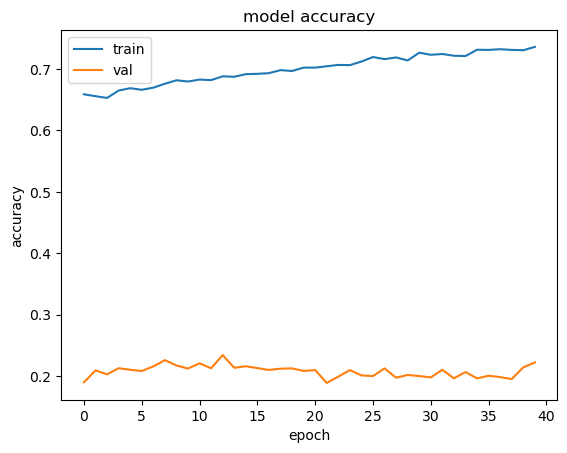

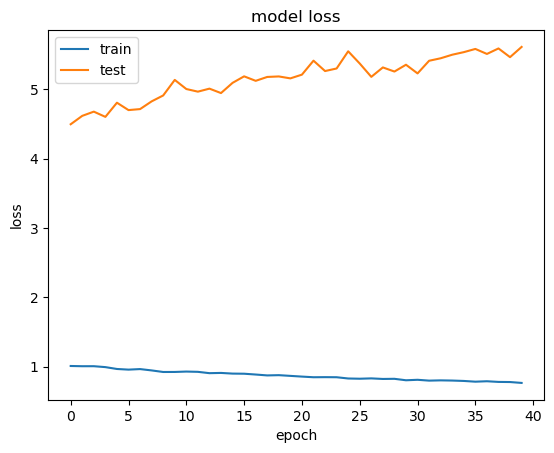

In [45]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's find how many correctly classified instances we get

In [41]:
count_train = Counter(y_train)
def pred_stats(X = X_test,y = y_test):
    correct = {}
    pred = model.predict(X)
    for i,j in enumerate(pred.argmax(axis=1)):
        if y[i] == words[j]:
            correct[y[i]] = correct.get(y[i],0) + 1
    count_test = Counter(y)
    pred_stats = []
    for word in words:
        row_data = {"word": word, "correct_count": correct.get(word, 0), "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
        pred_stats.append(row_data)

    stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    return stats
stats = pred_stats(X = X_val,y = y_val)
#stats = pred_stats(X = X_test,y = y_test)

stats = stats.loc[:,['word','correct_count','appeared_test']]
stats = stats.sort_values('appeared_test',ascending=False).reset_index(drop=True)
not_in_test = np.sum((stats.appeared_test==0))
stats.loc[:,'ratio'] = (100000 * stats.correct_count[:-not_in_test] / stats.appeared_test[:-not_in_test]).astype(int)/1000
stats = stats.sort_values('ratio',ascending=False).reset_index(drop=True)

display(stats)
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

116/116 [==============================] - 1s 10ms/step


,word,correct_count,appeared_test,ratio
0,shirt,155,155,100.000
1,walk,248,373,66.487
2,empty,0,126,0.000
3,small,0,25,0.000
4,morning,0,35,0.000
5,lazy,0,47,0.000
6,basketball,0,55,0.000
7,taste,0,56,0.000
8,dress,0,58,0.000
9,top,0,61,0.000


The mean and median amount of instances per word in the train set are: 2177.4193548387098 1735.0


In [75]:
model.save('/Users/oren/Documents/School/ai/sign_to_text/sign-to-text-interface/serving/landmark_nn/6/sign_to_text.keras')